# Assignment 6. Basics of deep learning models
## General Assignment. Transfer learning

In this task, we will learn how to use transfer learning and fine-tuning techniques using the example of the task of recognizing hot dogs.

After completing this task, you will have the opportunity to participate in the Kaggle In-Class training competition and compare your results with other course participants.

Participation is completely optional and optional to complete the course. Instructions and details - at the end of the notebook!

This assignment requires GPU access.

It could be a GPU from NVidia on your machine, then it is recommended to install GPU-enabled PyTorch via Conda - https://pytorch.org/get-started/locally/

If you don't have a GPU, you can use [Google Colab] (https://colab.research.google.com/), which provides free access to GPUs in the cloud.

Google Colab setup tutorial:
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d
(You don't need to install Keras, our notebook will install PyTorch by itself)



Transfer learning and fine-tuning

One of the most important techniques in training networks is to use pre-trained weights on a more general task as a starting point, and then "train" them on a specific one.

This approach both speeds up learning and allows you to train efficient models on small datasets.

In this exercise, we will train a classifier that classify hot dogs from non-hot dogs!

This task requires access to the GPU, so it can be performed either on a computer with an NVidia GPU or in [Google Colab] (https://colab.research.google.com/).

In [1]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image
import glob

from socket import timeout

import torch.nn as nn
import torch.optim as optim

import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
import torch.nn.functional as F
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.sampler import Sampler
import sklearn.metrics as metrics

First, let's download the data with pictures. This will do the code in the next cell. The data will be split into two parts. On the training set, which will be stored in the ** train_kaggle ** folder, we will build our models, and on the test set ** test_kaggle ** we will predict the class to which the photo belongs (hot dog or not).

### If you are on Google Colab!

It can run notebooks with GPU access. They are not very fast, but they are free!
Each notebook gets its own environment with an available disk, etc.

After 90 minutes of inactivity, this environment disappears with all the data.
Therefore, we will have to download the data every time.

In [2]:
train_folder = "train_kaggle/"
test_folder = "test_kaggle/"

In [3]:
# Download train data
# !wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
# !unzip -q "train.zip"

# 
# # Count number of files in the train folder, should be 4603
# print('Number of files in the train folder', len(os.listdir(train_folder)))

# # Download test data
# !wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
# !unzip -q "test.zip"

# # Count number of files in the test folder, should be 1150
# print('Number of files in the test folder', len(os.listdir(test_folder)))

In [4]:
%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available!

# Implementing your Dataset to load data

In this task, we will implement our own Dataset class for loading data. Goal is to load data from disk and generate a tensor with the network input, label and image ID (this will make it easier to prepare a submission for kaggle on test data).

Here is a link that explains well how to do this with an example: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Your Dataset should display the number of files in a folder as the number of samples and be able to display a tuple from a sample, a score by index and file name.
If the file name begins with the words 'frankfurter', 'chili-dog' or 'hotdog', the label is positive. Otherwise negative (zero).

And don't forget to support the ability to transform the input (the `transforms` argument), we'll need it!

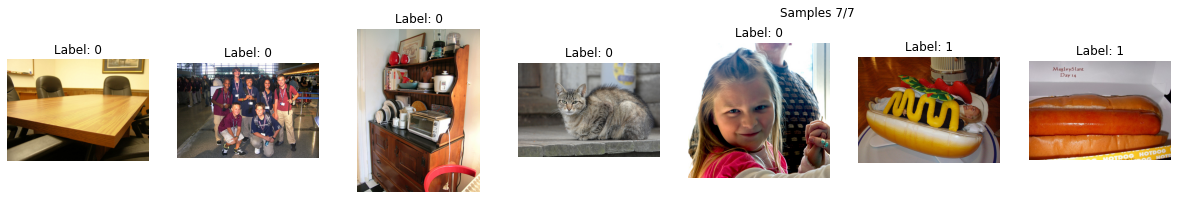

In [5]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, is_train, transform=None):
        self._is_train = is_train
        self.transform = transform
        
        self._data_folder = folder
        self._positive_classes_labels = ['frankfurter', 'chili-dog','hotdog']
        
        # self._data_paths = [os.path.join(folder, item)for item in os.listdir(self._data_folder) if item.endswith(".jpg")]
        self._data_paths = glob.glob(f"{self._data_folder}/*.jpg")
        
    def __len__(self):
        return len(self._data_paths)
    
    def __getitem__(self, index):        
        
        item  = self._data_paths[index]
        filename = os.path.basename(item)
        
        image_name = filename.split('.')[0]
        
        if self._is_train:
            # read true label and idx
            img_class_label, img_id = image_name.split('_')[:2]
            y = 1 if img_class_label in self._positive_classes_labels else 0
        else:
            y = None
            img_id = image_name
        
        # read image
        img = Image.open(item)
        
        if self.transform:
#             img = np.asarray(img, dtype=np.float32)
#             img = self.transform(image=img)["image"]
            img = self.transform(img)
        
        return img, y, img_id

def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
orig_dataset = HotdogOrNotDataset(train_folder, is_train=True)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

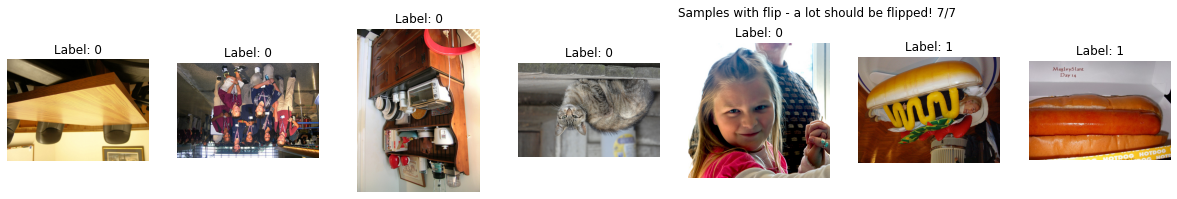

In [6]:
# Let's make sure transforms work!
dataset = HotdogOrNotDataset(train_folder, is_train=True, transform=transforms.RandomVerticalFlip(0.5))

visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

# Create Dataset for the training

And we divide it into train and validation.
We will train the model on train, check its quality for validation, and we will hold the Kaggle In-Class competition on photos from the test_kaggle folder.

In [7]:
# First, lets load the dataset

train_transform_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])       
])

train_transform_orig = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])       
])

test_transform_orig = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])       
])


train_dataset = HotdogOrNotDataset(train_folder, 
                                   is_train=True,
                                   transform=train_transform_orig
                                  )

val_dataset = HotdogOrNotDataset(train_folder, 
                                   is_train=True,
                                   transform=test_transform_orig
                                  )

test_dataset = HotdogOrNotDataset(test_folder,
                        is_train=False,
                       transform=test_transform_orig                         
                      )

In [8]:
batch_size = 64  
num_workers = 4

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         sampler=val_sampler, num_workers=num_workers)
# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

In [9]:
def binary_classification_metrics(prediction, ground_truth):
    tp = np.sum((ground_truth == True) & (prediction == True))
    fp = np.sum((ground_truth == False) & (prediction == True))
    fn = np.sum((ground_truth == True) & (prediction == False))
    
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    accuracy = np.sum((ground_truth == prediction))/len(ground_truth)
    f1 = 2 * precision * recall/(precision + recall)
    
    return precision, recall, f1

Our usual training functions

In [10]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None, dump_best=False):    
    loss_history = []
    train_history = []
    val_history = []
    
    best_val_accuracy = 0.0
    
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        
        if scheduler:
            scheduler.step()

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        if dump_best and val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pt')   
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    total_acc = []
    
    ground_truth, predictions = [], []
    
    for x, y, _ in loader:        
        ground_truth.extend(y.cpu().numpy())
        
        x = x.to(device)
        y = y.to(device)            
        pred = model(x)    
                     
        acc = torch.mean((pred.argmax(axis=1) == y).float())
        total_acc.append(acc)

        _, inds = torch.max(pred, 1)
        predictions.extend(inds.cpu().numpy())    
    
    precision, recall, f1 = binary_classification_metrics(np.asarray(predictions, dtype=np.float32), np.asarray(ground_truth))
    print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))
    return torch.mean(torch.stack(total_acc)).item()


# Using a pretrained network

Most often, the pre-trained network is a network trained on ImageNet data with 1M images and 1000 classes.

PyTorch includes such trained networks for various architectures (https://pytorch.org/docs/stable/torchvision/models.html)
We will be using ResNet18.

First, let's see what the already trained network gives out in our pictures. That is, let's see which of the 1000 classes the network assigns them to.

Run the model on 10 random images from the dataset and output them together with the classes with the highest probability.
There is already code in the code that generates the correspondence between the indices in the output vector and the ImageNet classes.

In [11]:
# Thanks to https://discuss.pytorch.org/t/imagenet-classes/4923/2
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    
    # TODO: Process it to return dict of class index to name
    return { int(k): v[-1] for k, v in classes.items()}


def denorm_tensor(tensor):
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    denormalize = transforms.Normalize((-1 * mean / std), (1.0 / std))

    # res = img.squeeze(0)
    res = denormalize(tensor)

    #Image needs to be clipped since the denormalize function will map some
    #values below 0 and above 1
    res = torch.clamp(res, 0, 1)
    
    return res
    
# 0 - 255, uint8
# 0 - 1 -> float32

@torch.no_grad()
def visualize_predictions(data_loader, model, title=None, count=10):
    imagenet_classes = load_imagenet_classes()
    
    count = min(count, len(data_loader))
    
    plt.figure(figsize=(count*3,3))
    # plt.suptitle("%s %s/%s" % (title, count, count))       
    
    for img_batch, label, _ in data_loader:
        img_batch = img_batch.to(device)
        
        scores_batch = model(img_batch)

        img_batch = img_batch[:count, ...]
        scores_batch = scores_batch[:count, ...]
        
        max_batch, y_batch = torch.max(scores_batch, -1)
        
        for i, (x, y, s) in enumerate(zip(img_batch, y_batch, max_batch)):
            
            x = denorm_tensor(x)
            x = x.permute(1, 2, 0).cpu().numpy()
            
            y = y.cpu().numpy()
        
            plt.subplot(1,count,i+1)
            plt.title(f"Label: {imagenet_classes[y.item()]} \n score: {s.item():.2f}")
            img = np.asarray(255 * x, dtype=np.uint8) 
            plt.imshow(img)
            plt.grid(False)
            plt.axis('off')
        
        break


In [12]:
torch.cuda.is_available()

True

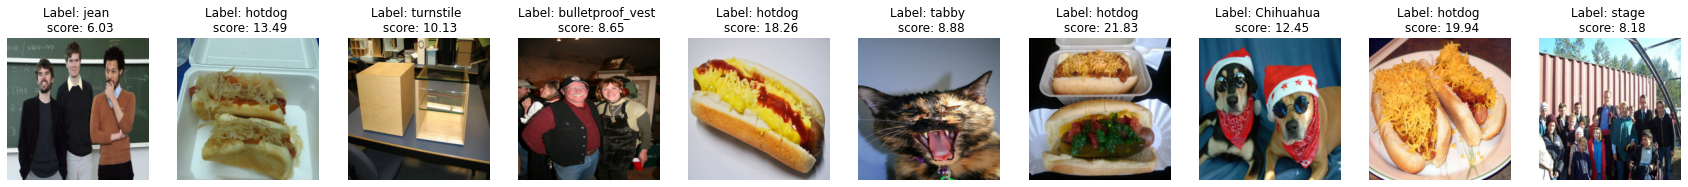

In [13]:
# TODO: Run this model on 10 random images of your dataset and visualize what it predicts
model = models.resnet18(pretrained=True)
model = model.to(device)
model = model.eval()

visualize_predictions(val_loader, model, count=10)

# Transfer learning - train only the last layer

There are several options for transfer learning, we will try the main ones.
The first option is to replace the last layer with a new one and train only it, freezing others.

In [17]:
model_tune_head = models.resnet18(pretrained=True)
# TODO: Freeze all the layers of this model and add a new output layer
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

print(model_tune_head)

for param in model_tune_head.parameters():
    param.requires_grad = False

model_tune_head.fc = nn.Linear(model_tune_head.fc.in_features, 2)  # 512 -> 2   # 512 - 64 - 2 

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_tune_head.parameters(), lr=0.001, momentum=0.9)
model_tune_head = model_tune_head.to(device)
loss_history, train_history, val_history = train_model(model_tune_head, train_loader, val_loader, loss, optimizer, 5)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Transfer learning - train the whole model

The second option is to replace the last layer with a new one in the same way and train the entire model.

In [18]:
model_tune_backbone = models.resnet18(pretrained=True)
# TODO: Add a new output layer and train the whole model
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

model_tune_backbone.fc = nn.Linear(model_tune_backbone.fc.in_features, 2)
model_tune_backbone = model_tune_backbone.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_tune_backbone.parameters(), lr=0.001, momentum=0.9)

loss_history, train_history, val_history = train_model(model_tune_backbone, train_loader, val_loader, loss, optimizer, 5)

F1: 0.906, P: 0.882, R: 0.932
Average loss: 0.313260, Train accuracy: 0.863155, Val accuracy: 0.942014
F1: 0.915, P: 0.903, R: 0.929
Average loss: 0.144080, Train accuracy: 0.944067, Val accuracy: 0.948264
F1: 0.922, P: 0.915, R: 0.929
Average loss: 0.095998, Train accuracy: 0.967418, Val accuracy: 0.950695
F1: 0.917, P: 0.924, R: 0.911
Average loss: 0.067221, Train accuracy: 0.978007, Val accuracy: 0.950347
F1: 0.916, P: 0.918, R: 0.914
Average loss: 0.044909, Train accuracy: 0.990768, Val accuracy: 0.947569


# Transfer learning - different learning rates for different layers

And finally, the last option that we will consider is to use different learning rates for new and old layers.

In [19]:
model_rates_layers = models.resnet18(pretrained=True)
# TODO: Add a new output layer
# Train new layer with learning speed 0.001 and old layers with 0.0001
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
loss = nn.CrossEntropyLoss()


rates_parameters = [{'params': model_rates_layers.conv1.parameters(), "lr": 0.0001}, 
    {'params': model_rates_layers.bn1.parameters(), "lr": 0.0001}, 
    {'params': model_rates_layers.layer1.parameters(), "lr": 0.0001}, 
    {'params': model_rates_layers.layer2.parameters(), "lr": 0.0001}, 
    {'params': model_rates_layers.layer3.parameters(), "lr": 0.0001}, 
    {'params': model_rates_layers.layer4.parameters(), "lr": 0.001},  
    {"params": model_rates_layers.fc.parameters(), "lr": 0.001},
    ]

model_rates_layers = model_rates_layers.to(device)

optimizer =  optim.SGD(rates_parameters, lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model_rates_layers, train_loader, val_loader, loss, optimizer, 5)

F1: 0.872, P: 0.938, R: 0.814
Average loss: 1.803385, Train accuracy: 0.733098, Val accuracy: 0.926736
F1: 0.889, P: 0.920, R: 0.861
Average loss: 0.150223, Train accuracy: 0.943524, Val accuracy: 0.934028
F1: 0.906, P: 0.953, R: 0.864
Average loss: 0.094708, Train accuracy: 0.964703, Val accuracy: 0.947917
F1: 0.904, P: 0.935, R: 0.875
Average loss: 0.061415, Train accuracy: 0.978550, Val accuracy: 0.944097
F1: 0.913, P: 0.926, R: 0.900
Average loss: 0.044963, Train accuracy: 0.986153, Val accuracy: 0.948264


# Visualizing model metrics and errors

Let's try to see where the model goes wrong - visualizing false positives and false negatives.

To do this, we'll run the model through all the examples and compare it to the ground truth.

In [28]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

    
@torch.no_grad()
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    predictions = []
    ground_truth = []
    
    cur_sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size, 
                                         sampler=cur_sampler,
                                         num_workers=2)
    for i_step, (x, y, _) in enumerate(loader):
        
        ground_truth.extend(y)
        
        x = x.to(device)
        y = y.to(device)            
        pred = model(x)    

        _, inds = torch.max(pred, 1)
        inds = inds.to('cpu', torch.double)
        predictions.extend(inds.numpy().tolist())    
    
    return np.array(predictions), np.array(ground_truth)

In [15]:
predictions, gt = evaluate_model(model_tune_head, train_dataset, val_indices)

NameError: name 'model_tune_head' is not defined

And now we can render false positives and false negatives.

In [25]:
# TODO: Compute indices of the false positives on the validation set.
# Note those have to be indices of the original dataset
false_positive_indices = np.array(val_indices)[((gt == False) & (predictions == True))].tolist()
visualize_samples(orig_dataset, false_positive_indices, "False positives")

# TODO: Compute indices of the false negatives on the validation set.
# Note those have to be indices of the original dataset
false_negatives_indices = np.array(val_indices)[((gt == True) & (predictions == False))].tolist()
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")


NameError: name 'gt' is not defined

# What will happen at the end you already understood

Train the best model based on `resnet18`, changing only the training process.
Choose the best model by F1 score.

As always, don't forget:
- more agmentation!
- enumeration of hyperparameters
- various optimizers
- what layers to tune
- learning rate annealing
- what epoch to stop at

Our goal is to bring the F1 score on the validation set to a value greater than ** 0.93 **.

In [13]:
# Recreate train loader with aufmentations

train_dataset = HotdogOrNotDataset(train_folder, 
                                   is_train=True,
                                   transform=train_transform_orig
                                  )

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)

In [23]:
best_model = models.resnet18(pretrained=True)
best_model.train()

best_model.fc = nn.Linear(best_model.fc.in_features, 2)
# best_model.fc = nn.Sequential(nn.Linear(best_model.fc.in_features, 64), nn.ReLU(inplace=True), nn.Linear(64, 2))
best_model = best_model.to(device)

In [24]:
n_epochs = 10

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=0.0001, weight_decay=1e-5)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 5)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [25]:
loss_history, train_history, val_history = train_model(best_model, train_loader, val_loader, loss, optimizer, n_epochs, scheduler, dump_best=True)

F1: 0.895, P: 0.854, R: 0.939
Average loss: 0.201000, Train accuracy: 0.922346, Val accuracy: 0.933681
F1: 0.928, P: 0.938, R: 0.918
Average loss: 0.036144, Train accuracy: 0.991854, Val accuracy: 0.958333
F1: 0.918, P: 0.957, R: 0.882
Average loss: 0.010490, Train accuracy: 0.997828, Val accuracy: 0.952431
F1: 0.925, P: 0.928, R: 0.921
Average loss: 0.004099, Train accuracy: 0.999728, Val accuracy: 0.956250
F1: 0.925, P: 0.948, R: 0.904
Average loss: 0.002140, Train accuracy: 1.000000, Val accuracy: 0.955556
F1: 0.930, P: 0.955, R: 0.907
Average loss: 0.002305, Train accuracy: 1.000000, Val accuracy: 0.958681
F1: 0.940, P: 0.952, R: 0.929
Average loss: 0.001079, Train accuracy: 1.000000, Val accuracy: 0.963889
F1: 0.929, P: 0.948, R: 0.911
Average loss: 0.001041, Train accuracy: 1.000000, Val accuracy: 0.957639
F1: 0.933, P: 0.942, R: 0.925
Average loss: 0.000934, Train accuracy: 1.000000, Val accuracy: 0.961458
F1: 0.935, P: 0.949, R: 0.921
Average loss: 0.000890, Train accuracy: 1.0

# Load best model, visualize losses and FP/FN predictions

In [29]:
# Load best checkpoint
best_model.load_state_dict(torch.load("best_model.pt"))
best_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
# Let's check how it performs on validation set!
predictions, ground_truth = evaluate_model(best_model, val_dataset, val_indices)
precision, recall, f1 = binary_classification_metrics(predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.940, P: 0.952, R: 0.929


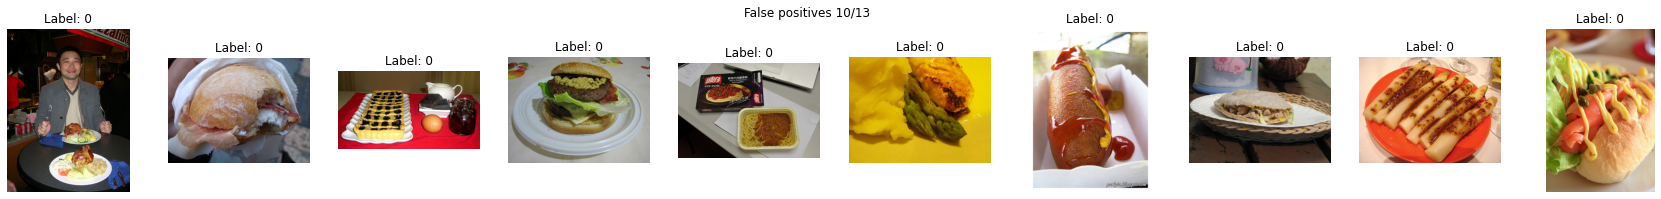

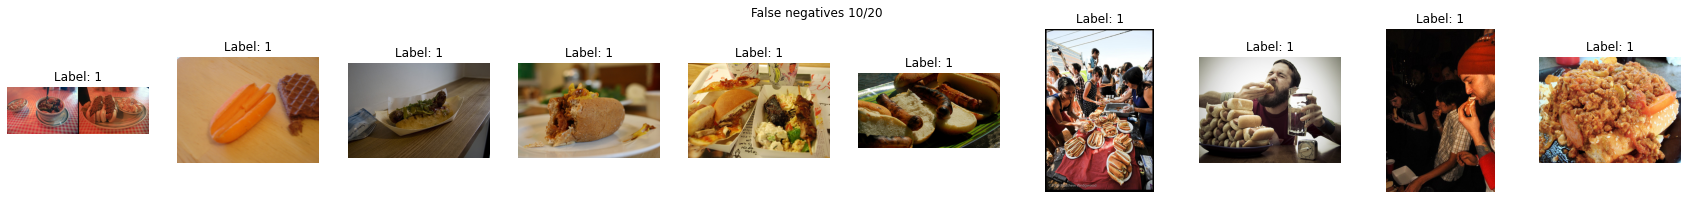

In [31]:
# TODO Visualize false positives and false negatives of the best model on the validation set
false_positive_indices = np.array(val_indices)[((ground_truth == False) & (predictions == True))].tolist()
visualize_samples(orig_dataset, false_positive_indices, "False positives")

false_negatives_indices = np.array(val_indices)[((ground_truth == True) & (predictions == False))].tolist()
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")

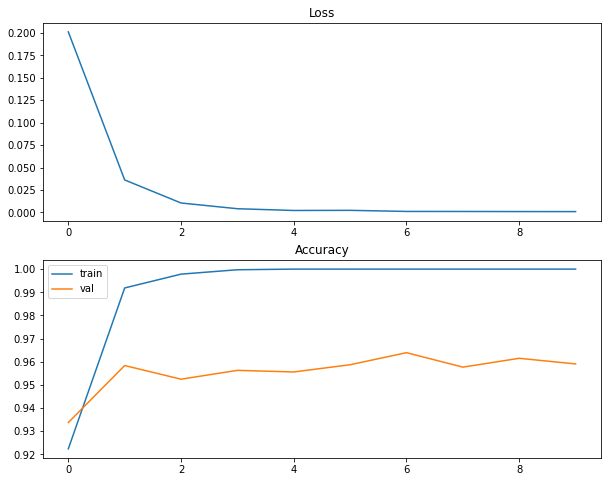

In [32]:
# TODO: Visualize training curve for the best model
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
ax[0].plot(loss_history)
ax[1].plot(train_history, label='train')
ax[1].plot(val_history, label='val')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
plt.legend()
plt.show()